# [Demo] Identification of the $\pi$ pulse

In [1]:
import os
import copy
import numpy as np
import scipy.optimize as sciopt
import matplotlib.pyplot as plt
import rqutils.paulis as paulis
import qudit_sim

qudit_sim.config.jax_devices = [0, 1]

try:
    os.mkdir('pi_pulse')
except FileExistsError:
    pass

## System Hamiltonian

We will run the simulations in the ququadrit space and extract qutrit operators from the results.

In [2]:
hgen = qudit_sim.HamiltonianGenerator(4)
hgen.add_qudit(qubit_frequency=3.e+10, anharmonicity=-2.e+9, drive_amplitude=1.5e+9, qudit_id='q0')

## Effective Hamiltonian of a qubit-resonant drive

First we apply a constant drive and identify which terms are present in the qutrit effective Hamiltonian.

In [3]:
hgen.clear_drive()

num_cycles = 400
test_amplitude = 0.2

hgen.add_drive('q0', frequency=hgen.frame('q0').frequency[0], amplitude=test_amplitude)
hgen.generate()
max_frequency = hgen.max_frequency

In [4]:
sim_result = qudit_sim.pulse_sim(hgen, tlist=(10, num_cycles), rwa=False)
components = qudit_sim.find_heff(sim_result, comp_dim=3, save_result_to='pi_pulse/qubit_resonant')

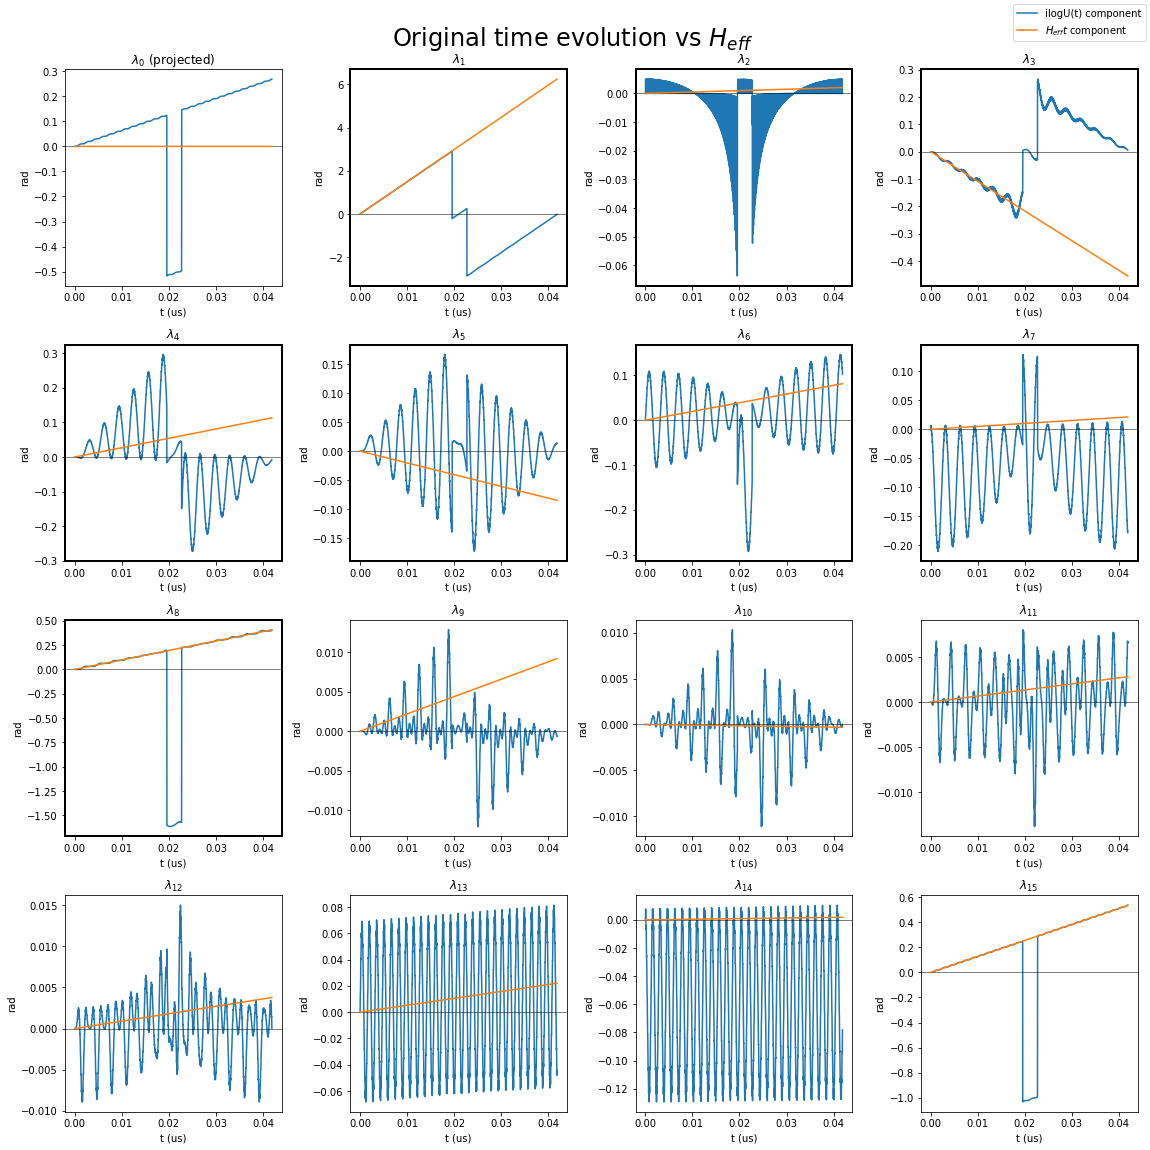

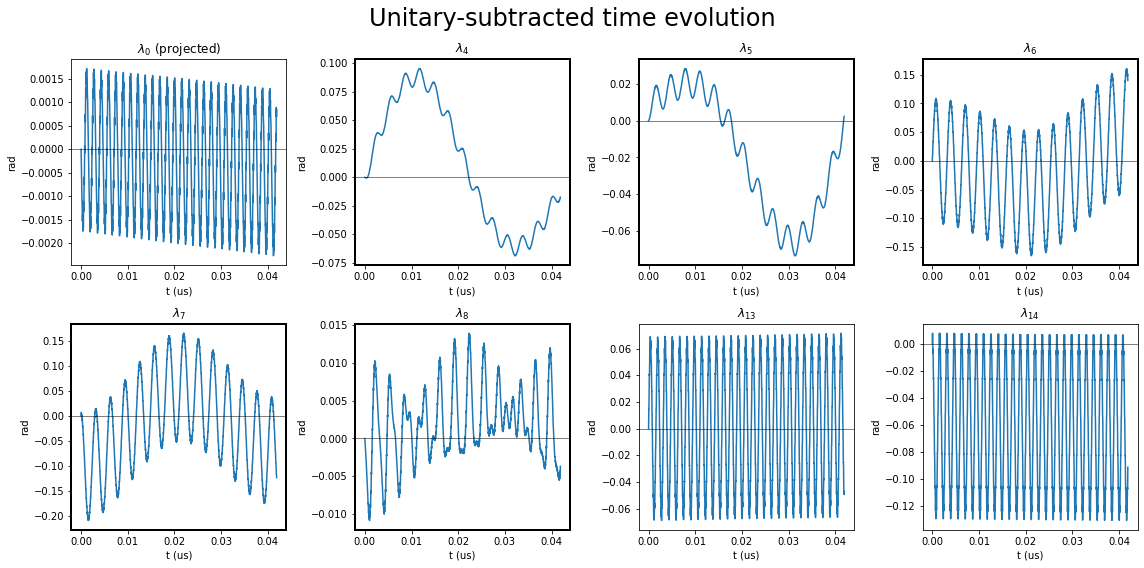

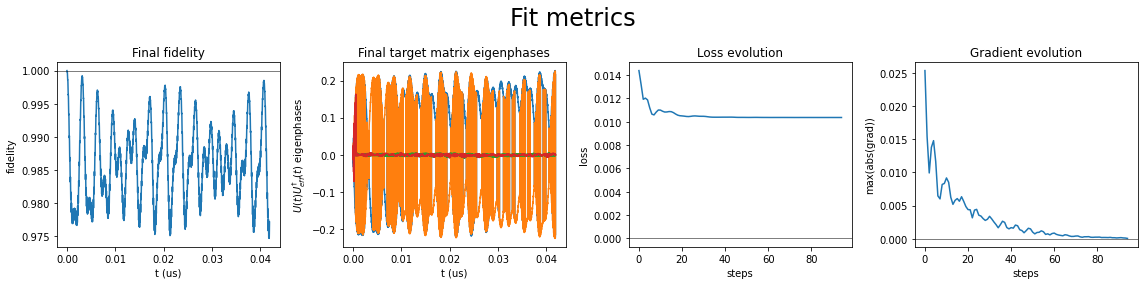

In [5]:
qudit_sim.heff.inspect_fidelity_maximization('pi_pulse/qubit_resonant.h5');

We see no long-term linear trends in the unitary-subtracted time evolution. Looks like the fit worked.

In [6]:
qudit_sim.print_components(components)

LaTeXRepr("\begin{split} \frac{H_{\mathrm{eff}}}{\mathrm{MHz}} = 1.016\lambda_{0} + 23.734\lambda_{1} - 1.725\lambda_{3} + 0.430\lambda_{4} - 0.322\lambda_{5} + 0.310\lambda_{6} + 0.081\lambda_{7} + 1.548\lambda_{8} \end{split}")

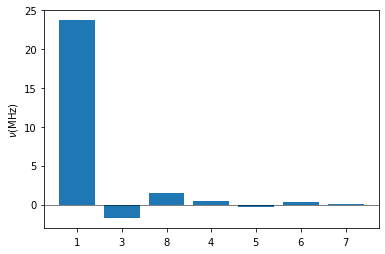

In [7]:
qudit_sim.plot_components(components);

Qubit-resonant drive is an off-resonant drive for the 1<->2 transition, generating an AC Stark term $\mathrm{diag}(0, 1, -1) = \lambda_8/2 - \lambda_3/2$. There are also small $\lambda_{\geq 4}$ components.

## Amplitude scan of qubit-resonant drive

We try to see if there is an amplitude that maximally suppresses $\lambda_4$ with respect to $\lambda_1$.

In [8]:
hgen.clear_drive()

amplitudes = np.linspace(-0.5, 0.5, 20)

hgens = hgen.make_scan('amplitude', amplitudes, qudit_id='q0', frequency=hgen.frame('q0').frequency[0])

sim_results = qudit_sim.pulse_sim(hgens, tlist=(10, num_cycles), rwa=False)
components_list = qudit_sim.find_heff(sim_results, comp_dim=3)

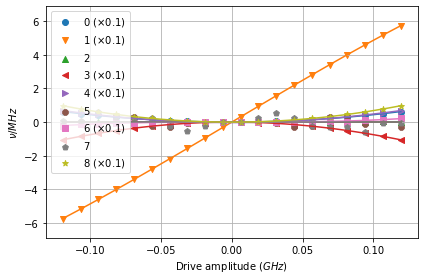

In [9]:
amp_base = hgen.qudit_params('q0').drive_amplitude
physical_amps = amp_base * amplitudes
fig, coefficients = qudit_sim.heff.plot_amplitude_scan(physical_amps, components_list)

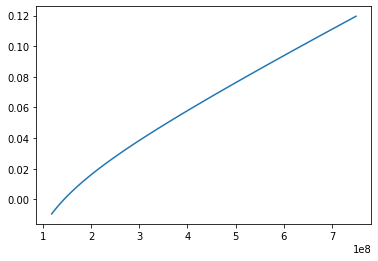

In [10]:
amplitudes_fine = np.linspace(physical_amps[11], physical_amps[-1], 100)
poly = lambda idx, x: np.sum(coefficients[idx] * np.power(np.asarray(x)[:, None], np.arange(5)), axis=1)
poly_amp = lambda idx: poly(idx, amplitudes_fine)
ratio_4to1 = poly_amp(4) / poly_amp(1)
plt.plot(amplitudes_fine, ratio_4to1);

Unfortunately, $\lambda_1$ component is linear in amplitude while $\lambda_4$ is quadratic or higher, so the lower the amplitude, the larger the suppression. But we want the amplitude to be high to make the $\pi$ pulse short.

Noting also that the $\lambda_4$ component can at some point reach 0, we move on and see if we are lucky to have small $\lambda_4$ for a given $\pi$ pulse length and amplitude.

## Gaussian pulse

We will ultimately find a DRAG pulse to implement $R_x(\pi)$, but we start with a Gaussian with a fixed duration and find the amplitude that gets us close to $\pi$.

In [11]:
hgen.clear_drive()

unit_time = 0.2e-9

duration = unit_time * 160
sigma = unit_time * 40

# approximate the Gaussian with a triangle -> area = amp * duration / 2.
rough_amp_estimate = np.pi / 2. / (components[1] / test_amplitude * duration / 2.)

amplitudes = rough_amp_estimate * np.linspace(0.8, 1.2, 20)
pulses = list(qudit_sim.Gaussian(duration=duration, amp=amp, sigma=sigma) for amp in amplitudes)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=hgen.frame('q0').frequency[0])

# max_frequency is actually angular frequency
cycle = 1. / max_frequency * 2. * np.pi
num_tpoints = int(duration / cycle) * 10
tlist = np.linspace(0., duration, num_tpoints)

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, rwa=False)
components_list = np.array(list(qudit_sim.gate_components(res) for res in sim_results))

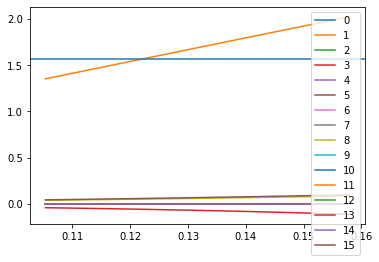

In [12]:
plt.plot(amplitudes, components_list, label=paulis.labels(4, norm=False, symbol=''))
plt.axhline(np.pi / 2.)
plt.legend();

In [13]:
line = lambda a, slope: a * slope
popt, _ = sciopt.curve_fit(line, amplitudes, components_list[:, 1], p0=rough_amp_estimate)
func = lambda x: x * popt[0] - np.pi / 2.
best_amplitude = sciopt.fsolve(func, rough_amp_estimate)

In [14]:
hgen.clear_drive()
pulse = qudit_sim.Gaussian(duration=duration, amp=best_amplitude, sigma=sigma)
hgen.add_drive('q0', frequency=hgen.frame('q0').frequency[0], amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, rwa=False)
components = qudit_sim.gate_components(sim_result)

In [15]:
qudit_sim.print_components(components, scale=None)

LaTeXRepr("\begin{split} i \mathrm{log} U = 1.572\lambda_{1} - 0.060\lambda_{3} + 0.051\lambda_{8} + 0.058\lambda_{15} \end{split}")

## DRAG pulse

Gaussian pulse effects non-negligible phase shifts due to the AC Stark shifts of $|1\rangle\leftrightarrow|2\rangle$ and $|2\rangle\leftrightarrow|3\rangle$ transitions. We seek to mitigate this effect by adding a derivative term to the pulse.

In [16]:
hgen.clear_drive()

betas = unit_time * np.linspace(0., 4., 20)
pulses = list(qudit_sim.Drag(duration=duration, amp=best_amplitude, sigma=sigma, beta=beta) for beta in betas)

hgens = hgen.make_scan('amplitude', pulses, qudit_id='q0', frequency=hgen.frame('q0').frequency[0])

sim_results = qudit_sim.pulse_sim(hgens, tlist=tlist, rwa=False)
components_list = np.array(list(qudit_sim.gate_components(res) for res in sim_results))

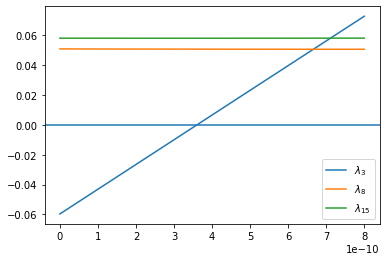

In [17]:
plt.plot(betas, components_list[:, 3], label=r'$\lambda_3$')
plt.plot(betas, components_list[:, 8], label=r'$\lambda_8$')
plt.plot(betas, components_list[:, 15], label=r'$\lambda_{15}$')
plt.axhline(0.)
plt.legend();

We see that DRAG does not affect $\lambda_8$ and $\lambda_{15}$ components, but can change the $\lambda_3$ component linearly with respect to the $\beta$ parameter.

In [18]:
line = lambda b, slope, intercept: b * slope + intercept
p0 = [(components_list[-1, 3] - components_list[0, 3]) / (betas[-1] - betas[0]), components_list[0, 3]]
popt, _ = sciopt.curve_fit(line, betas, components_list[:, 3], p0=p0)
func = lambda x: x * popt[0] + popt[1]
best_beta = sciopt.fsolve(func, 0.)

In [19]:
hgen.clear_drive()
pulse = qudit_sim.Drag(duration=duration, amp=best_amplitude, sigma=sigma, beta=best_beta)
hgen.add_drive('q0', frequency=hgen.frame('q0').frequency[0], amplitude=pulse)
sim_result = qudit_sim.pulse_sim(hgen, tlist=tlist, rwa=False)
components = qudit_sim.gate_components(sim_result)

In [20]:
qudit_sim.print_components(components, scale=None)

LaTeXRepr("\begin{split} i \mathrm{log} U = 1.573\lambda_{1} + 0.051\lambda_{8} + 0.058\lambda_{15} \end{split}")